#  Data Analysis Project on Israeli Protests on Twitter

Throughout this project, I aim to gain valuable insights into various aspects related to the ongoing protests in Israel using Twitter data:

1. Examining the characteristics of Twitter users involved in this case study, including their demographics and behavior, to better understand the context in which these protests are occurring.
2. Analyzing the most frequently used words in the tweets and identifying the emotions that characterize them, provides valuable insights into the prevailing sentiment surrounding the protests.
3. Identify significant trends or patterns in the tweets or user characteristics, helping to shed light on the underlying causes and motivations behind the ongoing protests in Israel.

In [43]:
import tweepy
import pandas as pd
import time
import datetime
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import string
from nltk.corpus import stopwords
nltk.download('punkt')
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
!pip install gender_guesser
import gender_guesser.detector as gender
!pip install wordcloud
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import collections
import seaborn as sns
import pytz
from collections import Counter

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Yakir\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yakir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yakir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Yakir\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yakir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Collection

* Personal twitter keys and Tokens

In [811]:
consumer_key = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
consumer_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
access_token = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
access_token_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [4]:
# Popular search terms related to protest
search_words = "(Israel OR Israeli OR #Israel) AND (supreme OR today OR judicial OR overhaul\
OR protest OR reform OR political OR discourse OR Protests OR rights OR situation OR public\
OR court  OR Judicial OR demonstration OR Court OR democracy OR Dictatorship\
OR Right OR Left OR government OR plan OR street OR people OR compromise OR public OR regime\
OR Netanyahu OR benjamin OR Lapid OR minister OR economic OR news OR institute) -filter:retweets"
# Date range
start_date = "2023-01-18"
end_date = "2023-03-27"
# Tweets limit
max_tweets = 10000
#Extract tweets
tweets = tweepy.Cursor(api.search_tweets,
              q=search_words,
              lang="en",
              since_id=start_date,
              until=end_date,
              tweet_mode='extended').items(max_tweets)

tweet_data = []
# colomns for the DF
for tweet in tweets:
    tweet_data.append({
        "id": tweet.id_str,
        "created_at": tweet.created_at,
        "full_text": tweet.full_text,
        "user_screen_name": tweet.user.screen_name,
        "user_location": tweet.user.location,
        "user_followers_count": tweet.user.followers_count,
        "retweet_count": tweet.retweet_count,
        "favorite_count": tweet.favorite_count,
        "lang": tweet.lang,
        "source": tweet.source,
        "name": tweet.user.name,
        "user_description": tweet.user.description,
        "user_friends_count":tweet.user.friends_count,
        "user_statuses_count": tweet.user.statuses_count,
        "user_created_at":tweet.user.created_at,
        "user_verified":tweet.user.verified
    })

while True:
    limit_status = api.rate_limit_status()
    remaining_searches = limit_status['resources']['search']['/search/tweets']['remaining']
    if remaining_searches == 0:
        reset_time = limit_status['resources']['search']['/search/tweets']['reset']
        wait_time = reset_time - time.time() + 10  # Add 10 seconds to be safe
        print(f"Rate limit exceeded. Waiting for {wait_time / 60:.2f} minutes...")
        time.sleep(wait_time)
    else:
        time.sleep(60) 
        break
    
twitter = pd.DataFrame(tweet_data)
twitter.head()

,id,created_at,full_text,user_screen_name,user_location,user_followers_count,retweet_count,favorite_count,lang,source,name,user_description,user_friends_count,user_statuses_count,user_created_at,user_verified
0,1640140784199507970,2023-03-26 23:56:49+00:00,@BernieSpofforth Could you tell a bit more abo...,LeoVasanko,"Porto, Portugal",50,0,3,en,Twitter Web App,Leo,"Wizard of code, casting spells with AI, for fu...",104,1139,2022-11-25 05:21:49+00:00,False
1,1640140408171773952,2023-03-26 23:55:20+00:00,I was certain that #Netanyahu was simply negot...,jacksimony,New York City,489,0,1,en,Twitter for iPhone,Jack Simony,Jack Simony - Chairman of The Negotiation Inst...,742,1852,2010-07-05 04:21:41+00:00,False
2,1640140083645890561,2023-03-26 23:54:02+00:00,Israel's defense minister had been the first s...,ksdknews,"St. Louis, Missouri",249699,0,1,en,SocialNewsDesk,KSDK News,"We're 5 On Your Side for breaking news, weathe...",1592,281659,2009-05-27 16:45:59+00:00,True
3,1640139773456023559,2023-03-26 23:52:48+00:00,"""The State of Israel is in the greatest danger...",jerusalemofiron,,5104,0,2,en,Twitter Web App,Jerusalem of Iron 🇮🇱 עם ישראל חי,"Zionist, writer, cynical optimist. 🇺🇸 🇮🇱\nWork...",3135,27063,2017-01-20 22:32:07+00:00,False
4,1640139465023782912,2023-03-26 23:51:35+00:00,JUST IN - ALERT 🚨 After Netanyahu’s judicial r...,IngoG01,,32,1,0,en,Twitter for iPhone,Ingo Suerbier,,419,13268,2022-03-23 19:38:27+00:00,False


save to csv

In [5]:
# twitter.to_csv(f"twitter10-18.23.csv", index=False)
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
twitter.to_csv(f"twitter_{current_date}.csv", index=False)

Import data

In [4]:
twitter1 = pd.read_csv(r'c:\Users\Yakir\twitter_2023-03-19.csv')
twitter2 = pd.read_csv(r'c:\Users\Yakir\twitter10-18.23.csv')
twitter3 = pd.read_csv(r'c:\Users\Yakir\twitter_2023-03-27.csv')

In [5]:
twitter= pd.concat([twitter1,twitter2,twitter3]).drop_duplicates()
twitter.head()

,id,created_at,full_text,user_screen_name,user_location,user_followers_count,retweet_count,favorite_count,lang,source,name,user_description,user_friends_count,user_statuses_count,user_created_at,user_verified
0,1.635790e+18,2023-03-14 23:40:06+00:00,The Netanyahu government may have to compromis...,WSJopinion,New York,139064,1,3,en,SocialFlow,Wall Street Journal Opinion,Opinion & Commentary from The Wall Street Jour...,160,75831,2007-07-03 13:39:08+00:00,True
1,1.635770e+18,2023-03-14 22:32:00+00:00,"Since late January, hundreds of thousands of I...",MotherJones,NaN,829633,40,83,en,Sprout Social,Mother Jones,"Smart, fearless journalism. Reader-supported s...",249,258645,2008-12-31 17:21:13+00:00,True
2,1.635770e+18,2023-03-14 22:22:19+00:00,The Netanyahu government may have to compromis...,mike_bomb,NaN,33,0,0,en,Twitter Web App,Michael 🇺🇸 🇮🇱,Happy go lucky fellow,58,11606,2013-11-11 07:25:22+00:00,False
3,1.635740e+18,2023-03-14 20:28:06+00:00,Let me expand a little bit on my thread (quote...,novussubsole,NaN,323,4,7,en,Twitter Web App,Michael,פוסט-פוסטציוני עם פנים אנושיות.,389,33759,2017-07-17 14:17:43+00:00,False
4,1.635730e+18,2023-03-14 19:57:10+00:00,It’s obscene that the US government is funding...,GoldsteinBrooke,NaN,34399,27,47,en,Twitter for iPhone,Brooke Goldstein,Warrior to #EndJewHatred. Mom of 3 Boys. Exec ...,2896,14367,2011-10-20 01:41:21+00:00,True


In [12]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1949 entries, 0 to 758
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   id                    1949 non-null   float64            
 1   created_at            1949 non-null   datetime64[ns, UTC]
 2   full_text             1949 non-null   object             
 3   user_screen_name      1949 non-null   object             
 4   user_location         1408 non-null   object             
 5   user_followers_count  1949 non-null   int64              
 6   retweet_count         1949 non-null   int64              
 7   favorite_count        1949 non-null   int64              
 8   lang                  1949 non-null   object             
 9   source                1949 non-null   object             
 10  name                  1949 non-null   object             
 11  user_description      1831 non-null   object             
 12  user_fr

* change columns to date type

In [7]:
twitter['created_at'] = pd.to_datetime(twitter['created_at'])
twitter['user_created_at'] = pd.to_datetime(twitter['user_created_at'])

# Example of vader_lexicon on a sentence

In [8]:
text_1 = "This is a bad day! I don't like apple"
text_2 = "This is a great day! you love her"

sid = SentimentIntensityAnalyzer()

scores_text_1 = sid.polarity_scores(text_1)
scores_text_2 = sid.polarity_scores(text_2)

print(f'scores text_1 {scores_text_1}')
print(f'scores text_2 {scores_text_2}')

scores text_1 {'neg': 0.541, 'neu': 0.459, 'pos': 0.0, 'compound': -0.7097}
scores text_2 {'neg': 0.0, 'neu': 0.368, 'pos': 0.632, 'compound': 0.8622}


* Checking the text received in the tweets in order to understand which cleanings need to be done

In [9]:
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)
twitter['full_text']

0      The Netanyahu government may have to compromis...
1      Since late January, hundreds of thousands of I...
2      The Netanyahu government may have to compromis...
3      Let me expand a little bit on my thread (quote...
4      It’s obscene that the US government is funding...
                             ...                        
754    Israel's Prime Minister Benjamin Netanyahu has...
755    Mass protests have taken place for an 11th wee...
756    French President Macron warned Netanyahu again...
757    Joly tells Israel's government it should drop ...
758    For the past several months, people have been ...
Name: full_text, Length: 1949, dtype: object

# Data claning

To ensure accurate sentiment analysis, the text must be cleaned by removing meaningless words such as URLs, stop words ('what', 'who', 'this'...), punctuation, and numbers. Functions will be created to perform this cleaning process and the cleaned words will be moved to a new column.

In [13]:
def remove_urls(text):
    if not isinstance(text, str):
        return text
    return re.sub(r'http\S+', '', text)

def remove_punctuation(text):
    punctuation = set(string.punctuation)
    return ''.join(char for char in text if char not in punctuation)
def remove_stopwords(text):
    if not isinstance(text, str):
        return text
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    return ' '.join(token for token in tokens if token.lower() not in stop_words)
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    if isinstance(text, str):  
        tokens = word_tokenize(text)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(lemmatized_tokens)
    else:
        return ''


In [14]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [15]:
# mask = twitter['full_text'].str.startswith("RT @")
# twitter.loc[mask, 'text'] = twitter.loc[mask, 'full_text'].str.replace("RT @", "").str.split(':').str[1]
# twitter['text'] = twitter['text'].str.lower()

twitter['text'] = twitter['full_text'].str.lower()
twitter.drop_duplicates(subset=['full_text'], keep='first', inplace=True)

twitter.head()

,id,created_at,full_text,user_screen_name,user_location,user_followers_count,retweet_count,favorite_count,lang,source,name,user_description,user_friends_count,user_statuses_count,user_created_at,user_verified,text
0,1.635790e+18,2023-03-14 23:40:06+00:00,The Netanyahu government may have to compromis...,WSJopinion,New York,139064,1,3,en,SocialFlow,Wall Street Journal Opinion,Opinion & Commentary from The Wall Street Jour...,160,75831,2007-07-03 13:39:08+00:00,True,the netanyahu government may have to compromis...
1,1.635770e+18,2023-03-14 22:32:00+00:00,"Since late January, hundreds of thousands of I...",MotherJones,NaN,829633,40,83,en,Sprout Social,Mother Jones,"Smart, fearless journalism. Reader-supported s...",249,258645,2008-12-31 17:21:13+00:00,True,"since late january, hundreds of thousands of i..."
2,1.635770e+18,2023-03-14 22:22:19+00:00,The Netanyahu government may have to compromis...,mike_bomb,NaN,33,0,0,en,Twitter Web App,Michael 🇺🇸 🇮🇱,Happy go lucky fellow,58,11606,2013-11-11 07:25:22+00:00,False,the netanyahu government may have to compromis...
3,1.635740e+18,2023-03-14 20:28:06+00:00,Let me expand a little bit on my thread (quote...,novussubsole,NaN,323,4,7,en,Twitter Web App,Michael,פוסט-פוסטציוני עם פנים אנושיות.,389,33759,2017-07-17 14:17:43+00:00,False,let me expand a little bit on my thread (quote...
4,1.635730e+18,2023-03-14 19:57:10+00:00,It’s obscene that the US government is funding...,GoldsteinBrooke,NaN,34399,27,47,en,Twitter for iPhone,Brooke Goldstein,Warrior to #EndJewHatred. Mom of 3 Boys. Exec ...,2896,14367,2011-10-20 01:41:21+00:00,True,it’s obscene that the us government is funding...


* Applying the cleaning functions 

In [16]:
twitter['text'] = twitter['text'].apply(remove_urls)
twitter['text'] = twitter['text'].apply(remove_stopwords)
twitter['text'] = twitter['text'].fillna('').apply(remove_numbers)
twitter['text'] = twitter['text'].apply(lemmatize_text)
twitter['text'] = twitter['text'].fillna('').apply(remove_punctuation)

twitter.head()

,id,created_at,full_text,user_screen_name,user_location,user_followers_count,retweet_count,favorite_count,lang,source,name,user_description,user_friends_count,user_statuses_count,user_created_at,user_verified,text
0,1.635790e+18,2023-03-14 23:40:06+00:00,The Netanyahu government may have to compromis...,WSJopinion,New York,139064,1,3,en,SocialFlow,Wall Street Journal Opinion,Opinion & Commentary from The Wall Street Jour...,160,75831,2007-07-03 13:39:08+00:00,True,netanyahu government may compromise win enough...
1,1.635770e+18,2023-03-14 22:32:00+00:00,"Since late January, hundreds of thousands of I...",MotherJones,NaN,829633,40,83,en,Sprout Social,Mother Jones,"Smart, fearless journalism. Reader-supported s...",249,258645,2008-12-31 17:21:13+00:00,True,since late january hundred thousand israeli l...
2,1.635770e+18,2023-03-14 22:22:19+00:00,The Netanyahu government may have to compromis...,mike_bomb,NaN,33,0,0,en,Twitter Web App,Michael 🇺🇸 🇮🇱,Happy go lucky fellow,58,11606,2013-11-11 07:25:22+00:00,False,netanyahu government may compromise win enough...
3,1.635740e+18,2023-03-14 20:28:06+00:00,Let me expand a little bit on my thread (quote...,novussubsole,NaN,323,4,7,en,Twitter Web App,Michael,פוסט-פוסטציוני עם פנים אנושיות.,389,33759,2017-07-17 14:17:43+00:00,False,let expand little bit thread quoted demograp...
4,1.635730e+18,2023-03-14 19:57:10+00:00,It’s obscene that the US government is funding...,GoldsteinBrooke,NaN,34399,27,47,en,Twitter for iPhone,Brooke Goldstein,Warrior to #EndJewHatred. Mom of 3 Boys. Exec ...,2896,14367,2011-10-20 01:41:21+00:00,True,’ obscene u government funding demonstration n...


* Apply the analyzer to each text in the 'text' column and extract the sentiment scores

In [17]:
tw_sentiment = twitter.copy()

analyzer = SentimentIntensityAnalyzer()
sentiment = twitter['text'].apply(lambda text: analyzer.polarity_scores(text))
tw_sentiment[['neg', 'neu', 'pos', 'compound']] = pd.DataFrame(sentiment.tolist(), index=sentiment.index)

tw_sentiment.head()

,id,created_at,full_text,user_screen_name,user_location,user_followers_count,retweet_count,favorite_count,lang,source,...,user_description,user_friends_count,user_statuses_count,user_created_at,user_verified,text,neg,neu,pos,compound
0,1.635790e+18,2023-03-14 23:40:06+00:00,The Netanyahu government may have to compromis...,WSJopinion,New York,139064,1,3,en,SocialFlow,...,Opinion & Commentary from The Wall Street Jour...,160,75831,2007-07-03 13:39:08+00:00,True,netanyahu government may compromise win enough...,0.000,0.606,0.394,0.7579
1,1.635770e+18,2023-03-14 22:32:00+00:00,"Since late January, hundreds of thousands of I...",MotherJones,NaN,829633,40,83,en,Sprout Social,...,"Smart, fearless journalism. Reader-supported s...",249,258645,2008-12-31 17:21:13+00:00,True,since late january hundred thousand israeli l...,0.167,0.833,0.000,-0.4215
2,1.635770e+18,2023-03-14 22:22:19+00:00,The Netanyahu government may have to compromis...,mike_bomb,NaN,33,0,0,en,Twitter Web App,...,Happy go lucky fellow,58,11606,2013-11-11 07:25:22+00:00,False,netanyahu government may compromise win enough...,0.000,0.649,0.351,0.7579
3,1.635740e+18,2023-03-14 20:28:06+00:00,Let me expand a little bit on my thread (quote...,novussubsole,NaN,323,4,7,en,Twitter Web App,...,פוסט-פוסטציוני עם פנים אנושיות.,389,33759,2017-07-17 14:17:43+00:00,False,let expand little bit thread quoted demograp...,0.079,0.830,0.091,0.0772
4,1.635730e+18,2023-03-14 19:57:10+00:00,It’s obscene that the US government is funding...,GoldsteinBrooke,NaN,34399,27,47,en,Twitter for iPhone,...,Warrior to #EndJewHatred. Mom of 3 Boys. Exec ...,2896,14367,2011-10-20 01:41:21+00:00,True,’ obscene u government funding demonstration n...,0.391,0.391,0.219,-0.6597


# Date range

In [18]:
print('Min date:', tw_sentiment['created_at'].min())
print('Max date:', tw_sentiment['created_at'].max())

Min date: 2023-03-06 23:15:00+00:00
Max date: 2023-03-26 23:56:49+00:00


# Users location

In [26]:
tw_sentiment.drop('new_location', axis = 1, inplace = True)

In [38]:
# tw_sentiment['user_screen_name'].nunique()
# tw_sentiment.groupby('user_location')['id'].count()

tw_sentiment['new_location'] = tw_sentiment['user_location'].str.strip()
tw_sentiment['new_location'] = tw_sentiment['new_location'].replace('', 'unknown').fillna('unknown')

Israel_re = r'\b(Tel[\s-]?Aviv|Israel.*|.*Israel|ישראל|Jerusalem|Modi\'in Israelm|Israel|IsraelIsrael)\b'
USA_re = r'(?i)los angeles|.*Washington.*|.*New York.*|.*USA.*|.*United States.*|.*Big Apple.*|Brooklyn.*|California|NYC|^Texas|^Columbus|.*OH$|^United.*|America'
India_re = r'.*(?i)india.*|.*Mumbai.*|.*New Delhi.*'
London_re = r'.*(?i)London.*|.*UK|^Cambridge.*'

tw_sentiment['new_location'] = tw_sentiment['new_location'].str.replace(Israel_re, 'Israel', regex=True)
tw_sentiment['new_location'] = tw_sentiment['new_location'].str.replace(USA_re, 'United States', regex=True)
tw_sentiment['new_location'] = tw_sentiment['new_location'].str.replace(India_re, 'India', regex=True)
tw_sentiment['new_location'] = tw_sentiment['new_location'].str.replace(London_re, 'London', regex=True)

tw_sentiment.groupby('new_location').agg(num_users=('id','count')).sort_values('num_users', ascending=False).head(10)

,num_users
new_location,
unknown,431
United States,252
Israel,132
London,58
India,40
IsraelIsrael,22
Germany,18
Global,17
Ankara - TÜRKİYE,16


# What is the opinion of people from abroad?
* Not news people
* Not opinion leaders

In [39]:
not_verified = tw_sentiment['user_verified'] == False
not_Israel_tw = ~ tw_sentiment['user_location'].fillna('').str.contains('Israel')

people = ~tw_sentiment['user_screen_name'].str.contains('news|News|Russia|republic|^Politic.*')
friends= tw_sentiment['user_friends_count']<100
pd.set_option('display.max_colwidth', None)

tw_sentiment[['user_screen_name','full_text']][not_Israel_tw & not_verified &friends & people]

,user_screen_name,full_text
2,mike_bomb,The Netanyahu government may have to compromise to win enough public support to pass durable judicial reforms. https://t.co/T66nB83WQv via @WSJopinion
15,arafkarsh,"https://t.co/cIu72LpBzh\nIsrael witnessed its biggest protests as 1000s of demonstrators marched down the streets.\nThe protesters held rallies opposing Prime Minister Benjamin Netanyahu’s far-right government over judicial reforms, which they say threaten the country’s democracy."
34,NafYochanan,@urbanicGray @netanyahu Some of his audience does. He’s not wrong. Israel needs a Constitution and Judicial reform. No other country let’s judges choose their own. A balance is needed between all branches so the will of the people are ensured. The will of the people made him PM.
38,deenvoss,"Israel's business people, doctors and lawyers are leading protests over a government move to weaken the judiciary\n\n📎 Bloomberg (https://t.co/uBfriZ19D3)"
51,Stephen26451846,@AlanDersh \nThere is no fool like an old fool the judicial reform in Israel is all about Netanyahu arranging for his corruption trial to play out in his favour and the possibility of getting a convicted felon in Deri back into government. Shame on you.
...,...,...
667,LeoLorder,"🌍WORLD/ Israel: For 2 months now, Israelis have been protesting against the Government's planned Judicial Overhaul❗️\nhttps://t.co/9kpxR9Eg8G"
671,alestiklalen,"Protests in #Israel are now in their 11th week against the government's controversial judicial regulation, as Prime Minister #Netanyahu plans to push the legislation through https://t.co/ScJqaOl8f9"
674,oze_randi,"Judicial reform protests will end with blood on the street, organizer warns https://t.co/CpYaSBEXNO"
695,AmirAlhaj_ph,"March 17, 2023 Update: New Israel protests as Netanyahu rejects judicial reforms compromise #Israel #PR Go: https://t.co/CKXAjOIFRX https://t.co/HsH9kfAfRL"


# Verified users percentage

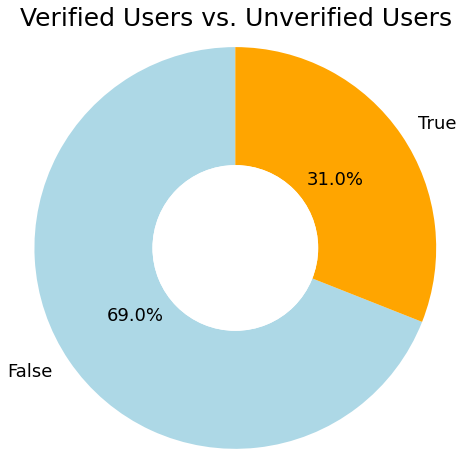

In [46]:
counts = tw_sentiment['user_verified'].value_counts()

fig, ax = plt.subplots(figsize=(8, 8))
outer = ax.pie(counts, radius=1, colors=['lightblue', 'orange'], labels=counts.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 18})
inner = ax.pie([1], radius=0.4, colors=['white'], wedgeprops={'linewidth': 5, 'edgecolor': 'white'})

center_circle = plt.Circle((0, 0), 0.4, color='white', linewidth=5)
fig.gca().add_artist(center_circle)

plt.title('Verified Users vs. Unverified Users', fontsize=25)
plt.axis('equal')

plt.show()


In [47]:
unique_users = tw_sentiment['user_screen_name'].nunique()
print(f'There are {unique_users} unique users')

There are 1030 unique users


# Who posted the most tweets on these topics?

In [48]:
tw_per_users = tw_sentiment.groupby(['name']).agg(
    number_tweets=('full_text','count')).sort_values('number_tweets', ascending=False)
tw_per_users.head(10)

,number_tweets
name,
The Jerusalem Post,52
Middle East Eye,21
Haaretz.com,19
Jewish Community,16
ANADOLU AGENCY,16
The New Arab,14
i24NEWS English,12
Andy Vermaut,11
Bloomberg,11


 # Popular source type

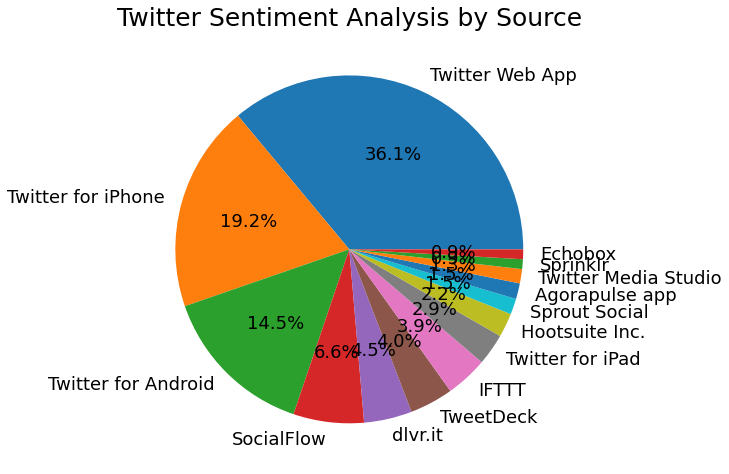

In [52]:
tw_sentiment_counts = tw_sentiment.groupby('source').agg(Source_type=('id', 'count')).sort_values('Source_type', ascending=False)
filtered_sources = tw_sentiment_counts[tw_sentiment_counts['Source_type'] > 10]
filtered_sources.plot.pie(y='Source_type', legend=False, figsize=(8, 8), fontsize=18, autopct='%1.1f%%'
                         , textprops={'color':"black", 'fontsize': 14})

plt.title('Twitter Sentiment Analysis by Source', fontsize=25)
plt.ylabel('')
plt.show()

# gender guesser

In [53]:
d = gender.Detector()

tw_sentiment['name_gender'] = tw_sentiment['name'].apply(lambda x: d.get_gender(x.split()[0]))

gender_counts = tw_sentiment.groupby('name_gender').size().sort_values(ascending=False)
gender_counts.to_frame()

,0
name_gender,
unknown,937
male,385
female,126
mostly_female,117
mostly_male,12
andy,7


In [54]:
Israel_tz = pytz.timezone('Israel') 
tw_sentiment['user_created_at'] = tw_sentiment['user_created_at'].dt.tz_convert(Israel_tz)
today = datetime.datetime.now(Israel_tz)
tw_sentiment['user_age'] = (today - tw_sentiment['user_created_at']).dt.total_seconds() / 31536000
avg = round(tw_sentiment['user_age'].mean(),2) 
print(f'The average years since the account creation is {avg}')

The average years since the account creation is 9.08


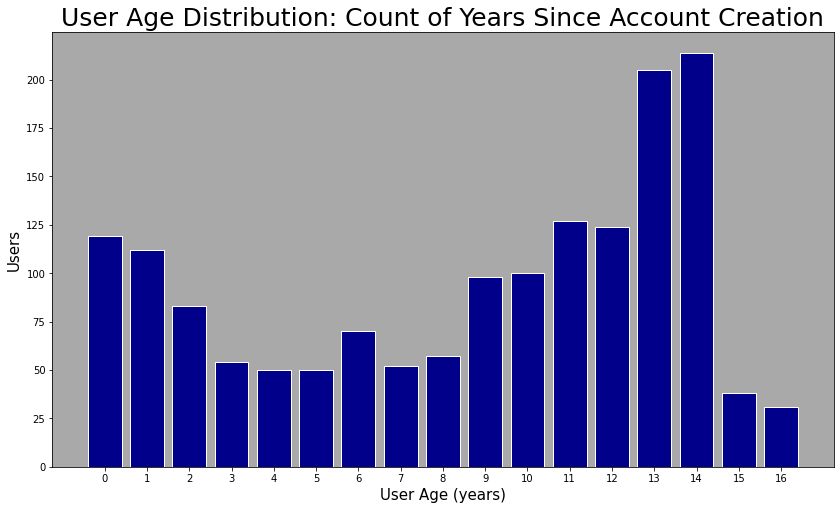

In [55]:
user_ages = tw_sentiment['user_age']
fig, ax = plt.subplots(figsize=(14,8))

bins = range(user_ages.astype(int).min(), user_ages.astype(int).max()+2)
hist, bins = np.histogram(user_ages, bins=bins)

plt.bar(bins[:-1], hist, width=0.8, align='center', color='darkblue', edgecolor='white')
plt.xticks(bins[:-1])
plt.xlabel('User Age (years)',fontsize=15)
plt.ylabel('Users',fontsize=15)
ax.set_title('User Age Distribution: Count of Years Since Account Creation', fontsize=25)

plt.gca().set_facecolor('darkgray')

plt.show()


For the purpose of the following analysis, I created a new DF that contains unique users only

In [56]:
new_df = tw_sentiment.drop_duplicates(subset=['user_screen_name'], keep='last')
new_df.head(2)

,id,created_at,full_text,user_screen_name,user_location,user_followers_count,retweet_count,favorite_count,lang,source,...,user_created_at,user_verified,text,neg,neu,pos,compound,new_location,name_gender,user_age
1,1.635770e+18,2023-03-14 22:32:00+00:00,"Since late January, hundreds of thousands of Israelis have been loudly protesting an impending judicial overhaul by the nation’s new right-wing government. https://t.co/0zSUSDgczB",MotherJones,NaN,829633,40,83,en,Sprout Social,...,2008-12-31 19:21:13+02:00,True,since late january hundred thousand israeli loudly protesting impending judicial overhaul nation ’ new rightwing government,0.167,0.833,0.000,-0.4215,unknown,unknown,14.243672
2,1.635770e+18,2023-03-14 22:22:19+00:00,The Netanyahu government may have to compromise to win enough public support to pass durable judicial reforms. https://t.co/T66nB83WQv via @WSJopinion,mike_bomb,NaN,33,0,0,en,Twitter Web App,...,2013-11-11 09:25:22+02:00,False,netanyahu government may compromise win enough public support pas durable judicial reform via wsjopinion,0.000,0.649,0.351,0.7579,unknown,male,9.379052


# Users with the most friends

In [58]:
users = new_df.groupby(['user_verified','user_screen_name','name']).agg(
    friends=('user_friends_count','sum')).sort_values('friends', ascending=False)
top_users = users[users['friends']>10000]
top_users.head(20)

friends
user_verified user_screen_name name                                               
False         krassenstein     Brian Krassenstein                           528419
              mcspocky         McSpocky™                                    192754
              realTuckFrumper  #TuckFrump                                   135031
True          NewsHour         PBS NewsHour                                  91588
False         BudGothmog44     Bud                                           79833
              USRealityCheck   Top U.S. & World News🗽                        74810
              johnharveyphoto  🌊🐶 John Harvey 📷🌊                             57682
              SocialistVoice   Socialist Voice ⭑                             50647
              kwikermoney      one media                                     46575
True          AdamMilstein     Adam Milstein                                 41028
False         AliceRothchild   Alice Rothchild, MD                           35876
              AndyVermaut      Andy Vermaut                                  34496
              RepublicPaper    Republic Paper ™                              32857
              endtimeslife     End Times Life                                32650
              pepesgrandma     Bad Kitty Unleashed 🦁💪🏻                       31227
              DenbrotS         Dennis S Brotman 🇺🇸 #DemCast #DemCastGA ☮️    27956
              Chris_1791       Chris 🇺🇸                                      25571
              AgenciaAJN       Agencia AJN                                   22667
              RonanLTynan      Ronan L Tynan                                 22329
              OldPrague        California🇺🇸🦅                                 21614

# Top users by number of tweets

In [59]:
tweets = new_df.groupby(['user_screen_name','name']).agg(
    Num_tweets=('user_statuses_count','sum')).sort_values('Num_tweets', ascending=False)
top_tweets = tweets[tweets['Num_tweets']>200000]
top_tweets

,,Num_tweets
user_screen_name,name,
AndyVermaut,Andy Vermaut,2216902
Chris_1791,Chris 🇺🇸,1875194
newsoneplace,NewsOnePlace.com,1825445
CrweWorld,Crwe World,1620794
AllTheNewsIsNow,🈂️🍆✊🤜🏾The Ambiguously Gay Duo Movie🤛🏾✊🍆🈂️,1563931
...,...,...
Mel_Ankoly,⚖️THEE Powerful Mel Ankoly 🇺🇦 #ForThePeople,205095
Filomen03258997,Filomena Rocha,203971
pbrown4348,Paul Brown,202656


# Top users according to two parameters and their sentiment average

In [60]:
filtered_tw_sentiment = new_df[(new_df['user_friends_count'] > 10000) & 
                                     (new_df['user_statuses_count'] > 200000)]
tweets = filtered_tw_sentiment.groupby(['user_screen_name','user_friends_count','user_statuses_count']).agg(
    Sentiment_score=('compound','mean')).sort_values(
    ['user_friends_count','user_statuses_count'], ascending=[False,False])

tweets

,,,Sentiment_score
user_screen_name,user_friends_count,user_statuses_count,
realTuckFrumper,135031,596048,-0.4215
NewsHour,91588,224851,0.0000
BudGothmog44,79833,571301,0.0000
USRealityCheck,74810,736974,-0.8689
SocialistVoice,50647,501154,-0.3182
AndyVermaut,34496,2216902,0.7650
pepesgrandma,31227,205891,0.4215
Chris_1791,25571,1875194,-0.2263
RiskAlert,17928,444160,0.0000


# Exploring the Connection Between Sentiment and Social Influence: 

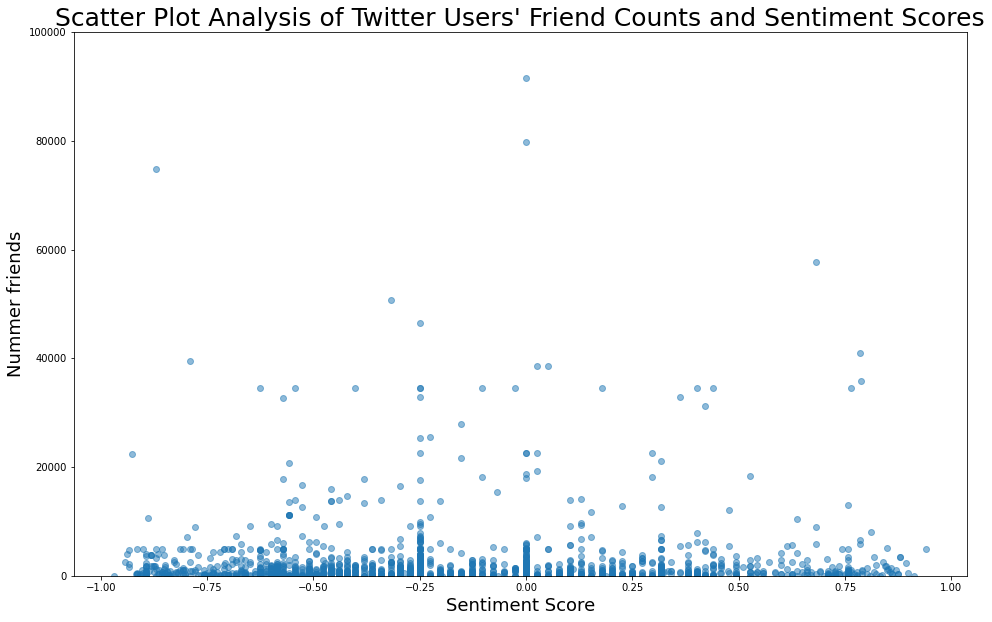

In [61]:
plt.figure(figsize=(16,10))

plt.scatter(tw_sentiment['compound'], tw_sentiment['user_friends_count'], alpha=0.5)

plt.title('Scatter Plot Analysis of Twitter Users\' Friend Counts and Sentiment Scores', fontsize=25)
plt.xlabel('Sentiment Score', fontsize=18)
plt.ylabel('Nummer friends', fontsize=18)
plt.ylim(0, 100000)

plt.show()

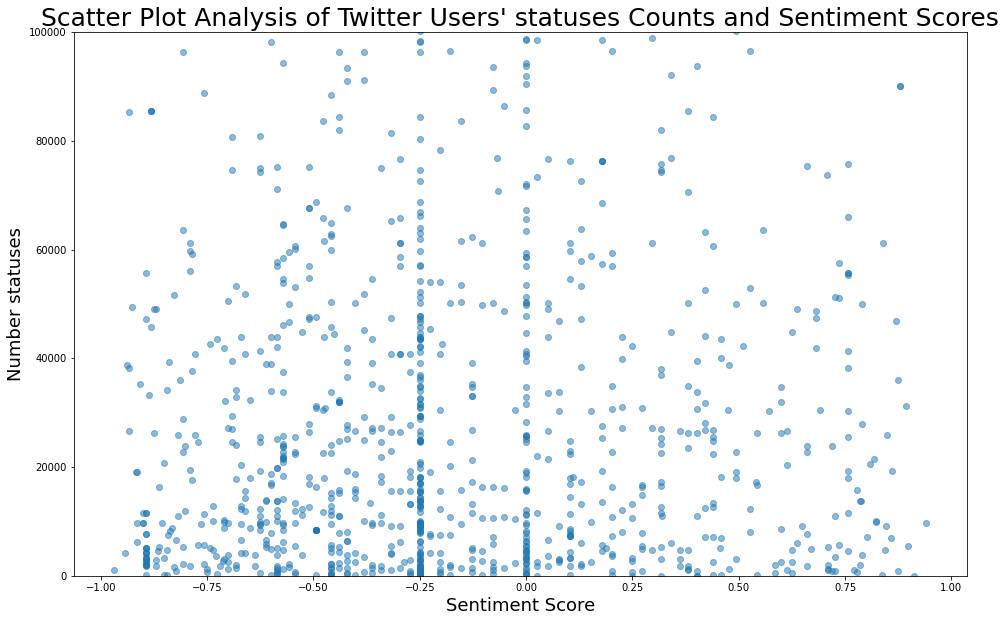

In [62]:
plt.figure(figsize=(16,10))

plt.scatter(tw_sentiment['compound'], tw_sentiment['user_statuses_count'], alpha=0.5)

plt.title('Scatter Plot Analysis of Twitter Users\' statuses Counts and Sentiment Scores', fontsize=25)
plt.xlabel('Sentiment Score', fontsize=18)
plt.ylabel('Number statuses', fontsize=18)
plt.ylim(0, 100000)

plt.show()

# Identifying the Tweets with the Highest Retweet Counts

In [63]:
column_list = ['user_screen_name','full_text','retweet_count']
num_retweet = tw_sentiment['retweet_count'] > 100

pd.set_option('display.max_colwidth', None) 
tw_sentiment[column_list][num_retweet].sort_values('retweet_count', ascending=False)

,user_screen_name,full_text,retweet_count
165,krassenstein,Citizens of Israel streamed into the streets today in Tel Aviv to protest against Netanyahu’s efforts to control the country’s judiciary. He has just fired Israel’s Defense minister for not supporting his judicial reform plan. \n\nProtesters held up this banner with images of… https://t.co/lZZbkXdYAY https://t.co/qKxEvmssdx,6557
93,TheInsiderPaper,"ALERT 🚨 After Netanyahu’s judicial reform plan:\n\n- massive protests in Israel\n\n- defense minister sacked\n\n- Israel’s consul general in New York quits\n\n- Israeli universities decided to stop studies \n\nLocation: Ayalon highway, Tel Aviv https://t.co/gYwtJGUamL",925
10,ClaraJeffery,The US media has been far too quiet about the protests riveting Israel. Something like 5% of Israel is in the streets. In the US that would equate to 16.5 million people. So we pulled together some photos to give you a sense of it: https://t.co/3Of2XcDDDG,647
28,pepesgrandma,The U.S. State Department has been funding a left-wing organization in Israel that is helping to promote anti-government protest aimed at bringing down Prime Minister Benjamin Netanyahu and his judicial reforms.\n\nhttps://t.co/jQBg5U7uqe,492
187,cnni,Half a million Israelis took to the streets in the tenth consecutive week of protests against plans by the government of Benjamin Netanyahu to overhaul the country’s judicial system\nhttps://t.co/GLPF3X1BSn,449
207,AJEnglish,Hundreds of thousands of people have rallied in cities across Israel for a 10th week to protest plans by Benjamin Netanyahu’s far-right government to curb the powers of the Supreme Court ⤵️ https://t.co/99rWgKPxlJ,428
65,Jerusalem_Post,"Hospitals, universities and labor workers have announced that they will be striking in response to Netanyahu's firing of Defense Minister Gallant and the government's on-going judicial reform legislation.\n\n#Strikes | #Israel | #Protests \n\nhttps://t.co/4M0A942lzm",206
170,CNN,Half a million Israelis took to the streets in the tenth consecutive week of protests against plans by the government of Benjamin Netanyahu to overhaul the country’s judicial system\nhttps://t.co/Cj8AX0XnPM,188
259,Nadav_Eyal,"1. In a major political development this evening, Israel's Defense Minister Yoav Galant has called for a ""pause"" in the legislation of the judicial overhaul led by the Netanyahu government. In Israel, the defense minister is regarded as the second most important minister",186
57,PeImeniPusha,"🇮🇱The situation in Israel is heating up.\n\n600-700 thousand people came out to protest against the judicial reform. The police make arrests, use special equipment.\n\nFormer Israeli Air Force commander Eitan Ben-Eliahu stated: ""[Prime Minister] Netanyahu has declared a civil war"".… https://t.co/es7Y9dn6Bd https://t.co/488K6W7k40",170


c:\users\yakir\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
c:\users\yakir\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


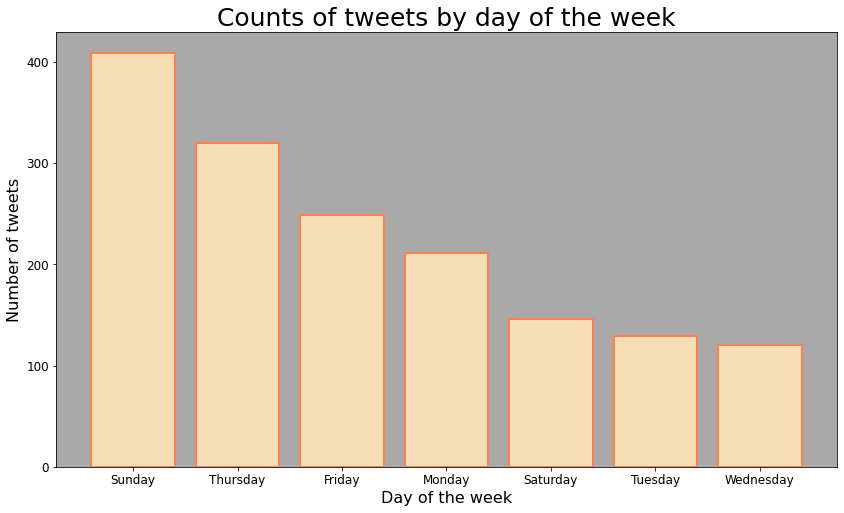

In [64]:
days_of_week = tw_sentiment.created_at.dt.day_name()
counts = days_of_week.value_counts()

fig, ax = plt.subplots(figsize=(14,8))
ax.bar(counts.index, counts.values,color='wheat',  edgecolor='coral', linewidth=2)
ax.set_xlabel('Day of the week', fontsize=16)
ax.set_ylabel('Number of tweets', fontsize=16)
ax.set_title('Counts of tweets by day of the week', fontsize=25)
ax.set_xticklabels(counts.index, fontsize=12)
ax.set_yticklabels(counts.values, fontsize=12)
ax.set_facecolor('darkgray')

ax.set_yticks(range(0, max(counts.values) + 1, 100))
ax.set_yticklabels(range(0, max(counts.values) + 1, 100), fontsize=12)

plt.show()

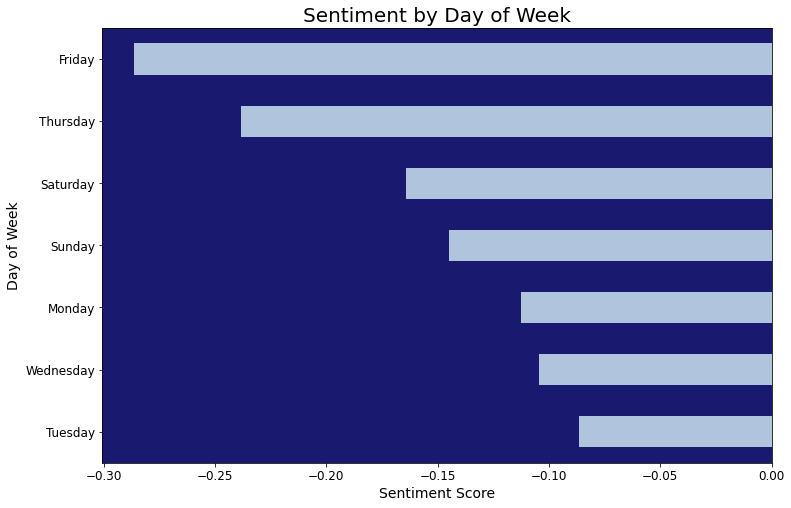

In [65]:
sentiment_by_day = tw_sentiment.groupby(days_of_week)['compound'].mean()

sentiment_by_day_sorted = sentiment_by_day.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
sentiment_by_day_sorted.plot(kind='barh', ax=ax,fontsize=12,color='lightsteelblue')
ax.set_xlabel('Sentiment Score',fontsize=14)
ax.set_ylabel('Day of Week',fontsize=14)
ax.set_title('Sentiment by Day of Week',fontsize=20)
ax.set_facecolor('midnightblue')
plt.show()

# Word Cloud

[('judicial', 1251), ('israel', 1103), ('netanyahu', 1044), ('protest', 975), ('government', 860), ('reform', 775), ('s', 757), ('israeli', 736), ('plan', 520), ('minister', 489), ('overhaul', 388), ('prime', 305), ('benjamin', 304), ('court', 254), ('people', 199), ('compromise', 197), ('country', 176), ('supreme', 161), ('system', 152), ('defense', 138), ('street', 133), ('week', 126), ('pm', 123), ('power', 116), ('thousand', 110)]


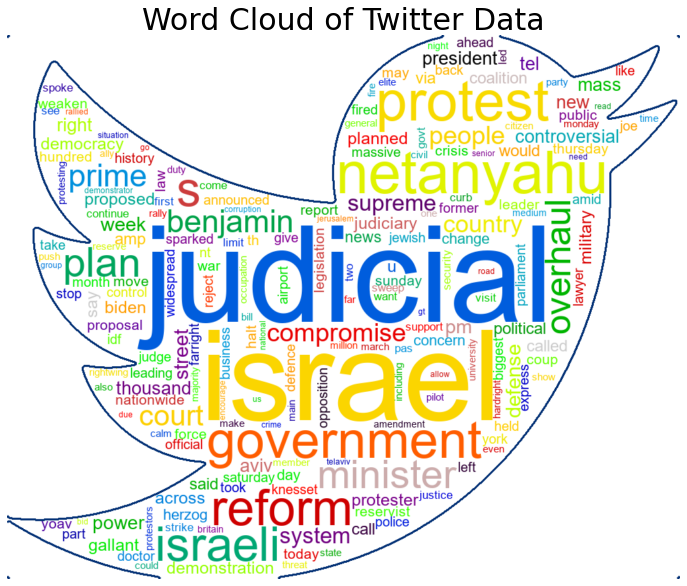

In [66]:
tokens = word_tokenize(' '.join(tw_sentiment['text'].tolist()))
filtered_tokens = [word for word in tokens if word.isalpha()]

freq_dist = nltk.FreqDist(filtered_tokens)
mask = np.array(Image.open(r'c:\Users\Yakir\twitter_mask.png'))

print(freq_dist.most_common(25))

wordcloud = WordCloud(mask=mask,background_color='white',contour_width=3,
                      contour_color='#023075',colormap='nipy_spectral',font_path='arial.ttf'
                     ).generate_from_frequencies(freq_dist)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Twitter Data', fontsize=30)
plt.show()

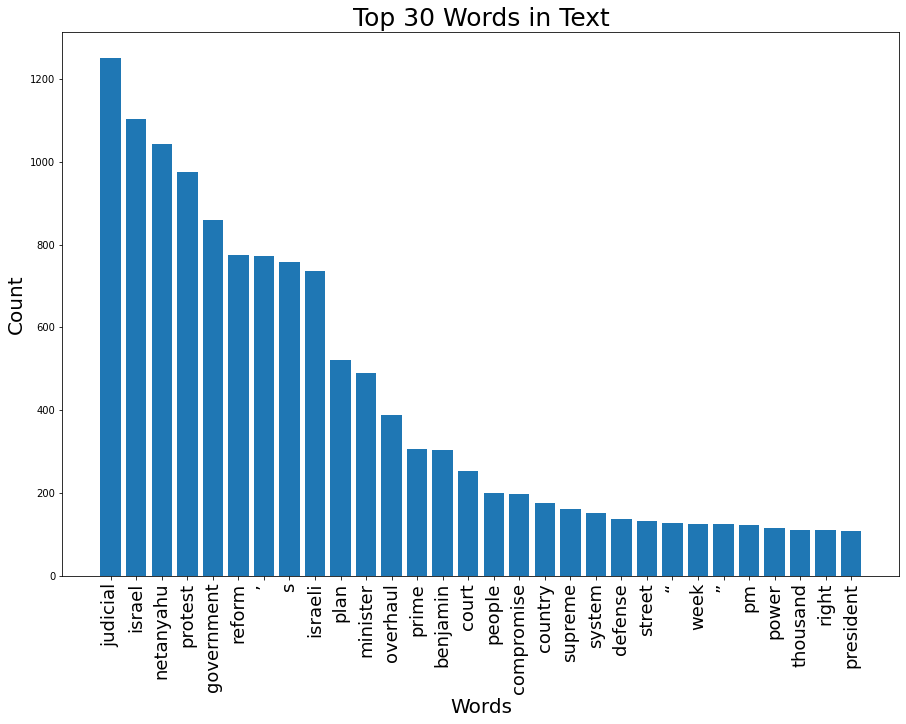

In [67]:
words = []
for text in tw_sentiment['text']:
    words += text.split()

word_counts = collections.Counter(words)

top_words = dict(word_counts.most_common(30))

fig, ax = plt.subplots(figsize=(15, 10))
plt.bar(top_words.keys(), top_words.values())
plt.xticks(rotation=90, fontsize=18)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Top 30 Words in Text', fontsize=25)
plt.show()


In [68]:
tw_sentiment['text'] = tw_sentiment['text'].str.replace(r'\bs\b', '')
tw_sentiment['text'] = tw_sentiment['text'].str.replace(r'\b\'\b', '')
tw_sentiment['text'] = tw_sentiment['text'].str.replace(r'\b\"\b', '')

# Popular words and their sentiment

In [70]:
words = tw_sentiment['text'].str.lower().str.split()
words = words.apply(remove_stopwords)
words = [word for tweet in words for word in tweet]
word_counts = Counter(words)
Popular_words = pd.DataFrame(columns=['word', 'count', 'sentiment'])

for word, count in word_counts.most_common(100):
    sentiment = sid.polarity_scores(word)['compound']
    Popular_words = Popular_words.append({'word': word, 'count': count, 'sentiment': sentiment}, ignore_index=True)

Popular_words.head(20)


,word,count,sentiment
0,judicial,1251,0.0000
1,israel,1103,0.0000
2,netanyahu,1044,0.0000
3,protest,975,-0.2500
4,government,860,0.0000
5,reform,775,0.0000
6,’,773,0.0000
7,israeli,736,0.0000
8,plan,520,0.0000
9,minister,489,0.0000


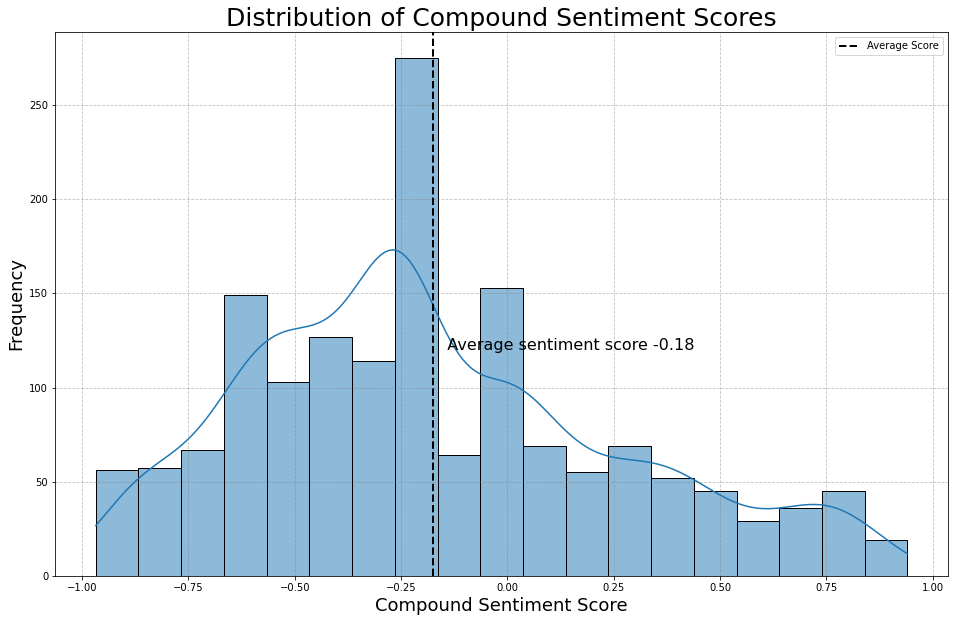

In [71]:
avg_score = tw_sentiment['compound'].mean()

fig, ax = plt.subplots(figsize=(16,10))
sns.histplot(tw_sentiment['compound'], kde=True)
ax.axvline(x=avg_score, linestyle='--', color='black', linewidth=2, label='Average Score')
ax.grid(True, which='major', color='gray', linestyle='--', alpha=0.5)


ax.legend()
ax.set_xlabel('Compound Sentiment Score', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_title('Distribution of Compound Sentiment Scores', fontsize=25)

ax.text(avg_score + 0.01, 120, f'  Average sentiment score {avg_score:.2f}', fontsize=16, color='black')


plt.show()


No handles with labels found to put in legend.


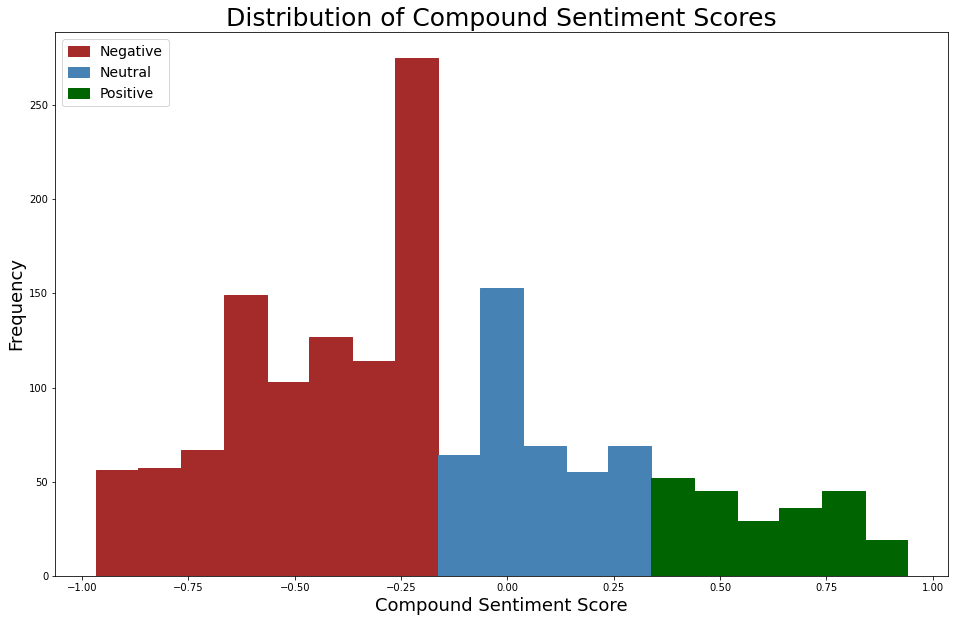

In [72]:
fig, ax = plt.subplots(figsize=(16,10))
sns.histplot(tw_sentiment['compound'])

ax.legend()
ax.set_xlabel('Compound Sentiment Score', fontsize=18)
ax.set_ylabel('Frequency', fontsize=18)
ax.set_title('Distribution of Compound Sentiment Scores', fontsize=25)

colors = ['brown', 'steelblue', 'darkgreen']
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in range(len(colors))]
legend_labels = ['Negative', 'Neutral', 'Positive']
ax.legend(handles, legend_labels, loc='upper left', fontsize=14, handlelength=1.5)

for rect in ax.patches:
    if rect.get_x() < -0.25:
        rect.set_color('brown')
    elif rect.get_x() < 0.25:
        rect.set_color('steelblue')
    else:
        rect.set_color('darkgreen')
        
plt.show()


# The most negative tweets

In [73]:
column_list = ['user_screen_name','full_text','text','neg']
new_column_names = {'text': 'lemmatize_text', 'neg': 'negative_score'}

new_df[column_list].rename(columns=new_column_names).sort_values('negative_score', ascending=False).head()

,user_screen_name,full_text,lemmatize_text,negative_score
581,angiesm53476550,"@urbanicGray @netanyahu Urbania Gray you are out of your mind, keep on protesting against your government and you will have more terrorist attacked, your enemy sees Israel isweak because of stupid protest of changing the power of Supreme Court, there is no problem in that.Your real threat is not PM.Bibi",urbanicgray netanyahu urbania gray mind keep protesting government terrorist attacked enemy see israel isweak stupid protest changing power supreme court problem thatyour real threat pmbibi,0.565
154,citizenyid,@NirBarkat Stop judicial reform.\nCorruption is contagious.\nhttps://t.co/PTienPYsVp,nirbarkat stop judicial reform corruption contagious,0.535
260,gbrew24,"Weeks of troubling signs--pilots refusing to fly, reservists failing to show up--has culminated in Israel's defense minister warning of a full mat-sec crisis if the govt carries out its judicial reform. https://t.co/yvuNNcQNm4",week troubling sign pilot refusing fly reservist failing show culminated israel s defense minister warning full matsec crisis govt carry judicial reform,0.492
344,Lynguist716,"EXACTLY....Autocrats &amp; Dictators SHOULD have to run and hide! This Jewish women is outraged by this Fascist Israeli Government, full of criminals.\nIsraelis protesting judicial reform force Netanyahu airlift https://t.co/BW9RsB9XXW",exactly autocrat amp dictator run hide jewish woman outraged fascist israeli government full criminal israeli protesting judicial reform force netanyahu airlift,0.484
216,deji_of_lagos,Protests resume in Israel after Netanyahu rejects compromise PM Netanyahu rejected a proposal from President Herzog that had attempted to diffuse the country's judicial crisis.,protest resume israel netanyahu reject compromise pm netanyahu rejected proposal president herzog attempted diffuse country s judicial crisis,0.482


# The most positive tweets

In [74]:
column_list = ['user_screen_name', 'full_text', 'text', 'pos']
new_column_names = {'text': 'lemmatize_text', 'pos': 'positive_score'}

new_df[column_list].rename(columns=new_column_names).sort_values('positive_score', ascending=False).head()

,user_screen_name,full_text,lemmatize_text,positive_score
161,commondreams,"On mass demonstrations, false hope, and why Israel's Supreme Court is no friend of the Palestinian people. https://t.co/TPr7LNeSrn",mass demonstration false hope israel s supreme court friend palestinian people,0.649
132,JackieRosenwald,The Israeli people are not having it. Good for them 👏 \n\nhttps://t.co/NpYZdKqYmB,israeli people good 👏,0.592
336,jewishwebsight,Justice minister hails proposed compromise on Israeli Supreme Court reform https://t.co/vjai0pNCtw,justice minister hail proposed compromise israeli supreme court reform,0.580
551,BrianGoredemaBr,An excellent appraisal of the Israeli government determination to take justice an human rights away from Palestinians \nhttps://t.co/34zHSD9PLV,excellent appraisal israeli government determination take justice human right away palestinian,0.551
192,OmarPie,"As some that loves visiting Israel, I loath @netanyahu with a passion. I hope the people make their voices heard and stop this overreach. \n\nhttps://t.co/RWwO9XnKaN",love visiting israel loath netanyahu passion hope people make voice heard stop overreach,0.474


# Conclusions

This project focused on analyzing public opinion on the ongoing protests in Israel using Twitter data. The results provide valuable insights into various aspects related to the ongoing protests in Israel, including the characteristics of Twitter users involved in the protests, the most frequently used words in the tweets, the prevailing sentiment surrounding the protests, and significant trends or patterns in the tweets or user characteristics.

First, we can see that there is a significant amount of international interest in the protests, as a large number of tweets came from outside of Israel. The United States had the highest number of tweets, followed by Israel, which suggests that people around the world are paying attention to this issue.

Second, we can see that the sentiment of the tweets tended to be negative overall, with an average sentiment score of -0.18. This negative sentiment was particularly strong on Sundays and Thursdays, which may be related to the fact that many of the protests took place on that day or the day before.

Third, we can see that there is a lot of media coverage of the protests, but there were still many tweets from private individuals expressing their opinions. The majority of these individuals appeared to be opposed to the legal revolution promoted by the government.

Fourth, the sentiment analysis of tweets posted by influential Twitter users showed that most of their tweets expressed negative sentiments toward the ongoing protests in Israel. However, it's important to note that while there is a correlation between high social involvement and negative sentiment, it's not clear whether there is a causal relationship between the two.

Finally, we should note that the results returned by VADER on the sentiment analysis were not always accurate, which suggests that this tool should be used with caution when analyzing Twitter data.

Overall, the analysis of Twitter data provides valuable insights into public opinion on the ongoing protests in Israel. By understanding the sentiment and characteristics of Twitter users involved in this issue, we can gain a better understanding of the underlying causes and motivations behind the protests. 